In [3]:
import numpy as np
import torch
from torch.nn import functional as F
from PIL import Image

from mujoco_gym import PickPlacePandaEnvController

%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.insert(0, "../vjepa2")
sys.path.insert(0, "../vjepa2/notebooks")

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import (
    compute_new_pose,
    poses_to_diff
)

# Initialize transform
crop_size = 256

transform = make_transforms(
    random_horizontal_flip=False,
    random_resize_aspect_ratio=(1., 1.),
    random_resize_scale=(1., 1.),
    reprob=0.,
    auto_augment=False,
    motion_shift=False,
    crop_size=crop_size,
)

In [5]:
from utils.world_model_wrapper import WorldModel

def forward_target(encoder, c, normalize_reps=True):
    #not sure what other stuff is doing but repeat is for the tubelet size of 2
    
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

def ac_next_action(world_model, clips, s_n):
    h = forward_target(world_model.encoder, clips)
    z_n, z_goal = h[:, :world_model.tokens_per_frame], h[:, -world_model.tokens_per_frame:]
    print(f"Starting planning using Cross-Entropy Method...")
    actions = world_model.infer_next_action(z_n, s_n, z_goal).cpu().numpy()
    
    return actions[0]

In [50]:
trajectory = np.load("../vjepa2/notebooks/franka_example_traj.npz")
np_clips = trajectory["observations"]

np_clips.shape

(1, 2, 256, 256, 3)

In [14]:
img_init = np.array(Image.open("outputs/capture_1765067328.7588298.png"))
img_goal = np.array(Image.open("outputs/capture_1765067409.3798451.png"))

np.stack([img_init, img_goal]).shape

transform(np.stack([img_init, img_goal])).unsqueeze(0).shape

torch.Size([1, 3, 2, 256, 256])

In [11]:
trajectory1 = np.load("outputs/capture_1768452136.134667.npz")
#trajectory2 = np.load("outputs/capture_1766723409.1077538.npz")
trajectory2 = np.load("outputs/capture_1768452194.7526774.npz")

clips = transform(np.stack([trajectory1['img'], trajectory2['img']])).unsqueeze(0)
s_n = torch.tensor(np.expand_dims(trajectory1['state'], (0,1))).float()

clips.shape
s_n.shape

torch.Size([1, 3, 2, 256, 256])

torch.Size([1, 1, 7])

array([ 5.02062119e-01, -5.56107669e-03,  1.37981873e-01, -1.79222288e+02,
       -2.12289689e-03,  8.99944799e+01,  4.00000009e-02])

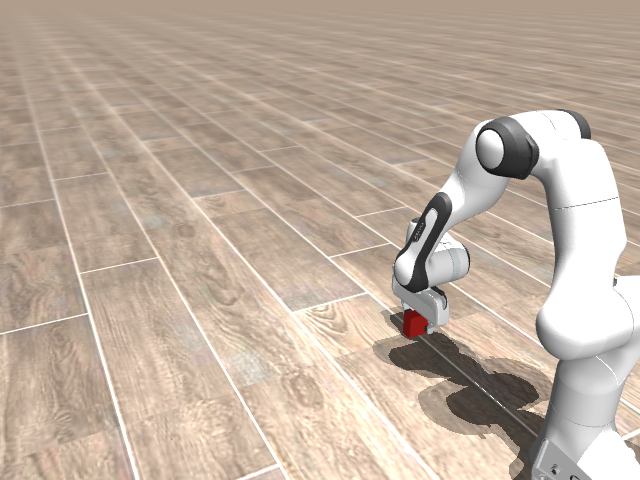

array([ 5.02476281e-01, -5.54054334e-03,  2.04733391e-01, -1.79201681e+02,
       -1.40932700e-03,  8.99986569e+01,  1.49467661e-02])

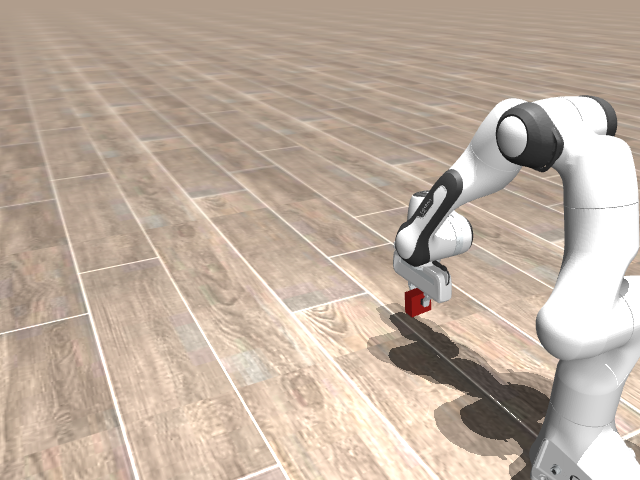

In [14]:
trajectory1['state']
Image.fromarray(trajectory1['img'])

trajectory2['state']
Image.fromarray(trajectory2['img'])

A:\code\conda_envs\vjepa\Lib\site-packages\gymnasium\spaces\box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
A:\code\conda_envs\vjepa\Lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


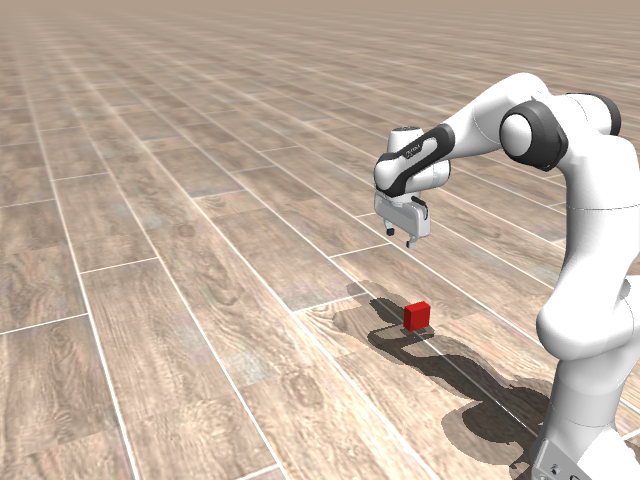

initial obs
[0.]
initial ctrl
[  0.   0.   0.   0.   0.   0.   0. 255.]
obs right after step
[0.]
ctrl right after step
[  0.   0.   0.   0.   0.   0.   0. 255.]
qpos right after step
0.04
qpos after 1000 steps
0.04000003722316351


In [15]:
import mujoco

env = PickPlacePandaEnvController(
        "C:\\Users\\gdev\\Documents\\CS\\DL\\projects\\Robotics\\custom_gym_env\\robots/franka_emika_panda/pick_place_custom.xml",
        render_mode="rgb_array", camera_name='fixed_cam', width=640, height=480, initial_pose='near_box')

obs, info = env.reset()

Image.fromarray(env.render())

#start open
print("initial obs")
print(obs[-1])
print("initial ctrl")
print(env.data.ctrl)

#obs, reward, terminated, truncated, info = env.step(np.array([0,0,0,0,0,0,1])) #close
print("obs right after step")
print(obs[-1])
print("ctrl right after step")
print(env.data.ctrl)
print("qpos right after step")
print(env.data.qpos[7])

for t in range(0, 1000):
    mujoco.mj_step(env.model, env.data)
    #obs, reward, terminated, truncated, info = env.step(np.array([0,0,0,0,0,0,-1]))

print("qpos after 1000 steps")
print(env.data.qpos[7])

In [33]:
encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant", pretrain=False)

tokens_per_frame = int((crop_size // encoder.patch_size) ** 2)
tokens_per_frame

# Doing very few CEM iterations with very few samples just to run efficiently on CPU...
# ... increase cem_steps and samples for more accurate optimization of energy landscape
MPC_ARGS = {
            "rollout": 1,
            "samples": 50,
            "topk": 10,
            "cem_steps": 2,
            "momentum_mean": 0.15,
            "momentum_mean_gripper": 0.15,
            "momentum_std": 0.75,
            "momentum_std_gripper": 0.15,
            "maxnorm": 0.075,
            "verbose": True
        }

world_model = WorldModel(
        encoder=encoder,
        predictor=predictor,
        tokens_per_frame=tokens_per_frame,
        transform=transform,
        mpc_args= MPC_ARGS,
        normalize_reps=True,
        device="cpu"
    )

#encoder(torch.randn(1, 3, 2, 256, 256)).shape

Using cache found in C:\Users\gdev/.cache\torch\hub\facebookresearch_vjepa2_main


256

In [32]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")

    for i in range(num_gpus):
        device_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {device_name}")

print(f"Model on GPU: {all(p.is_cuda for p in encoder.parameters())}")

Model on GPU: False


In [106]:
def forward_target(c, normalize_reps=True):
    #not sure what other stuff is doing but repeat is for the tubelet size of 2
    
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    if normalize_reps:
        h = F.layer_norm(h, (h.size(-1),))
    return h

In [107]:
def forward_actions(z, nsamples, grid_size=0.075, normalize_reps=True, action_repeat=1):

    def make_action_grid(grid_size=grid_size):
        action_samples = []
        for da in np.linspace(-grid_size, grid_size, nsamples):
            for db in np.linspace(-grid_size, grid_size, nsamples):
                for dc in np.linspace(-grid_size, grid_size, nsamples):
                    action_samples += [torch.tensor([da, db, dc, 0, 0, 0, 0], device=z.device, dtype=z.dtype)]
        return torch.stack(action_samples, dim=0).unsqueeze(1)

    # Sample grid of actions
    action_samples = make_action_grid()
    print(f"Sampled grid of actions; num actions = {len(action_samples)}")

    def step_predictor(_z, _a, _s):
        _z = predictor(_z, _a, _s)[:, -tokens_per_frame:]
        if normalize_reps:
            _z = F.layer_norm(_z, (_z.size(-1),))
        _s = compute_new_pose(_s[:, -1:], _a[:, -1:])
        return _z, _s

    # Context frame rep and context pose
    z_hat = z[:, :tokens_per_frame].repeat(int(nsamples**3), 1, 1)  # [S, N, D]
    s_hat = s_n.repeat((int(nsamples**3), 1, 1))  # [S, 1, 7]
    a_hat = action_samples  # [S, 1, 7]

    for _ in range(action_repeat):
        _z, _s = step_predictor(z_hat, a_hat, s_hat)
        z_hat = torch.cat([z_hat, _z], dim=1)
        s_hat = torch.cat([s_hat, _s], dim=1)
        a_hat = torch.cat([a_hat, action_samples], dim=1)

    return z_hat, s_hat, a_hat

def loss_fn(z, h):
    z, h = z[:, -tokens_per_frame:], h[:, -tokens_per_frame:]
    loss = torch.abs(z - h)  # [B, N, D]
    loss = torch.mean(loss, dim=[1, 2])
    return loss.tolist()

In [114]:
# Compute energy for cartesian action grid of size (nsample x nsamples x nsamples)
nsamples = 5
grid_size = 0.075
with torch.no_grad():
    h = forward_target(clips)
    z_hat, s_hat, a_hat = forward_actions(h, nsamples=nsamples, grid_size=grid_size)
    loss = loss_fn(z_hat, h)  # jepa prediction loss

Sampled grid of actions; num actions = 125


Text(0.5, 0, 'Action Delta x')

Text(0, 0.5, 'Action Delta y')

Text(0.5, 1.0, 'Energy Landscape')

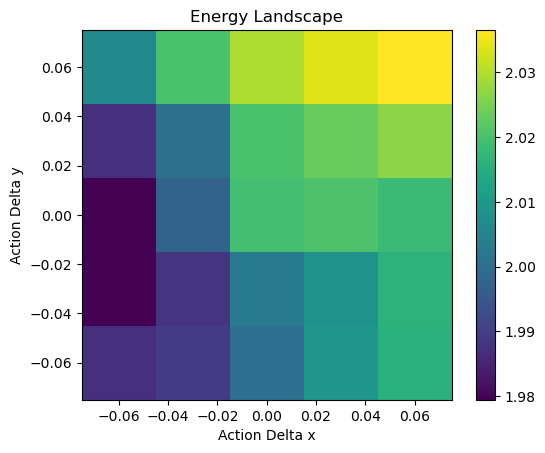

In [140]:
# Plot the energy

plot_data = []
for b, v in enumerate(loss):
    plot_data.append((
        a_hat[b, :-1, 0].sum(),
        a_hat[b, :-1, 1].sum(),
        a_hat[b, :-1, 2].sum(),
        v,
    ))

delta_x = [d[0] for d in plot_data]
delta_y = [d[1] for d in plot_data]
delta_z = [d[2] for d in plot_data]
energy = [d[3] for d in plot_data]

#gt_x = actions[0, 0, 0]
#gt_y = actions[0, 0, 1]
#gt_z = actions[0, 0, 2]

# Create the 2D histogram
heatmap, xedges, yedges = np.histogram2d(delta_x, delta_y, weights=energy, bins=nsamples)

# Set axis labels
plt.xlabel("Action Delta x")
plt.ylabel("Action Delta y")
plt.title(f"Energy Landscape")

# Display the heatmap
#print(f"Ground truth action (x,y,z) = ({gt_x:.2f},{gt_y:.2f},{gt_z:.2f})")
_ = plt.imshow(heatmap.T, origin="lower", extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap="viridis")
_ = plt.colorbar()

In [38]:
with torch.no_grad():
    h = forward_target(clips)
    z_n, z_goal = h[:, :tokens_per_frame], h[:, -tokens_per_frame:]
    s_n = torch.tensor(np.expand_dims(trajectory1['state'], (0,1))).float() #states[:, :1]

    print(f"h shape: {h.shape}")
    print(f"z_n shape: {z_n.shape}")
    print(f"z_goal shape: {z_goal.shape}")
    print(f"s_n shape: {s_n.shape}")

    print(f"Starting planning using Cross-Entropy Method...")
    actions = world_model.infer_next_action(z_n, s_n, z_goal).cpu().numpy()

print(f"Actions returned by planning with CEM (x,y,z) = ({actions[0, 0]:.2f},{actions[0, 1]:.2f} {actions[0, 2]:.2f})")

h shape: torch.Size([1, 512, 1408])
z_n shape: torch.Size([1, 256, 1408])
z_goal shape: torch.Size([1, 256, 1408])
s_n shape: torch.Size([1, 1, 7])
Starting planning using Cross-Entropy Method...
[INFO    ][2025-12-26 21:17:49][utils.mpc_utils     ][cem                      ] new mean: tensor([-0.0455, -0.0129,  0.0017,  0.0276]) tensor([0.1393, 0.1386, 0.1443, 1.2921])
[INFO    ][2025-12-26 21:19:46][utils.mpc_utils     ][cem                      ] new mean: tensor([-0.0410, -0.0210, -0.0144, -0.4078]) tensor([0.1306, 0.1302, 0.1320, 0.9378])
Actions returned by planning with CEM (x,y,z) = (-0.02,-0.00 -0.02)


In [ ]:
np.linalg.norm(trajectory2['state'][:3] - trajectory1['state'][:3], 2)
np.linalg.norm(trajectory2['state'][:3] - (s_n[0,0] + actions[0])[:3].numpy(), 2)

In [50]:
import time

env = PickPlacePandaEnvController(
        "C:\\Users\\gdev\\Documents\\CS\\DL\\projects\\Robotics\\custom_gym_env\\robots/franka_emika_panda/pick_place_custom.xml",
        render_mode="rgb_array", camera_name='fixed_cam', width=640, height=480, initial_pose='grasp')

img_goal = trajectory2['img']

obs, info = env.reset()
s_n = torch.tensor(np.expand_dims(np.concat(obs), (0,1))).float() #reshape obs for model
img_t = env.render()

actions_MPC = []
states_traj = [s_n] #compare actual states to those desired by actions_MPC to see if diff_IK does good job
imgs_traj = [img_t]

steps = 0
while steps < 5:
    start_time = time.time()
    
    clips = transform(np.stack([img_t, img_goal])).unsqueeze(0)
    with torch.no_grad():
        #CEM doesn't actually compute the orientation (it gets padded as zeros)
        action_MPC = ac_next_action(world_model, clips, s_n)
        #z_n is encapsulated in ac_next_action if want to plot l1 distance
    
    obs, reward, terminated, truncated, info = env.step(action_MPC)
    s_n = torch.tensor(np.expand_dims(np.concat(obs), (0,1))).float() #reshape obs for model
    img_t = env.render()
    
    actions_MPC.append(action_MPC)
    states_traj.append(s_n)
    imgs_traj.append(img_t)
    
    print(f"Control loop {steps} took {time.time() - start_time}")

    if terminated or truncated:
        break

    steps += 1

Starting planning using Cross-Entropy Method...
[INFO    ][2026-01-04 00:01:30][utils.mpc_utils     ][cem                      ] new mean: tensor([-0.0452, -0.0114, -0.0117,  0.1201]) tensor([0.0679, 0.0646, 0.0713, 0.7846])
[INFO    ][2026-01-04 00:02:35][utils.mpc_utils     ][cem                      ] new mean: tensor([-0.0531, -0.0569, -0.0058,  0.2049]) tensor([0.0578, 0.0539, 0.0722, 0.6544])
Received action, controller is trying to achieve target position
Controller error: [0.05305786 0.05689669 0.00577749], l2 dist: 0.07801121315086401
Controller error: [0.02318748 0.02498198 0.00334746], l2 dist: 0.034248556100520196
Controller error: [0.00647331 0.00687306 0.00164783], l2 dist: 0.0095842542356321
Controller error: [0.00171854 0.00170514 0.00071116], l2 dist: 0.002523217993980921
Control loop 0 took 137.95923709869385
Starting planning using Cross-Entropy Method...
[INFO    ][2026-01-04 00:03:48][utils.mpc_utils     ][cem                      ] new mean: tensor([-0.0233,  0.00

In [97]:
#"replay"

env = PickPlacePandaEnvController(
        "C:\\Users\\gdev\\Documents\\CS\\DL\\projects\\Robotics\\custom_gym_env\\robots/franka_emika_panda/pick_place_custom.xml",
        render_mode="rgb_array", camera_name='fixed_cam', width=640, height=480, initial_pose='grasp')

obs, info = env.reset()

traj_saved = np.load("outputs/pick_and_place_traj2.npz", allow_pickle=True)
actions_MPC = traj_saved['arr_0']
states_traj = traj_saved['arr_1']

steps = 0
while steps < 5: 
    obs, reward, terminated, truncated, info = env.step(actions_MPC[steps])

    if terminated or truncated:
        break

    steps += 1

Received action, controller is trying to achieve target position
Controller error: [0.07435308 0.00202091 0.07499958], l2 dist: 0.10562860376884348
Controller error: [0.03138103 0.00095781 0.03304556], l2 dist: 0.045581740746731575
Controller error: [0.00794685 0.0003253  0.00915033], l2 dist: 0.012123814213922626
Controller error: [1.87354394e-03 9.83417343e-05 2.26413710e-03], l2 dist: 0.002940434454149089
Received action, controller is trying to achieve target position
Controller error: [0.01032817 0.01041442 0.07426898], l2 dist: 0.07570345388020466
Controller error: [0.00244345 0.00452885 0.03191255], l2 dist: 0.03232478888721094
Controller error: [-0.00078096  0.00121639  0.00835017], l2 dist: 0.008474359662281035
Controller error: [-0.00063882  0.00029605  0.0019692 ], l2 dist: 0.002091291530565161
Received action, controller is trying to achieve target position
Controller error: [ 0.02066882 -0.02555403  0.03788857], l2 dist: 0.05015727089025955
Controller error: [ 0.0124258  -

In [105]:
len(env.frames)
actions_MPC[:,6]
states_traj[:,0,0,6]

175

array([ 0.0000000e+00,  9.9946952e-01,  8.0965483e-04, -1.9166643e-03,
        6.3626528e-02, -6.5077696e-04, -2.8185462e-04,  1.2335642e-05,
        1.4471632e-05,  2.6949501e-01,  6.3089484e-01,  3.2876208e-01,
        1.4146746e-04,  9.4231127e-06], dtype=float32)

array([ 0.        ,  0.        ,  0.29976222, -0.31344363,  0.        ,
        0.        , -0.26745102,  0.2722101 ,  0.6361068 ,  0.31750643,
       -0.33344883, -0.55632293,  0.        ], dtype=float32)

Load saved trajectory

array([[ 0.00375291,  0.00800446,  0.04596118],
       [ 0.00023101, -0.00183703,  0.01984704],
       [ 0.00165046,  0.00319351,  0.01976221]], dtype=float32)

array([0.32002008, 0.        , 0.        ], dtype=float32)

array([0.        , 0.31586775, 0.32000077, 0.32002145], dtype=float32)

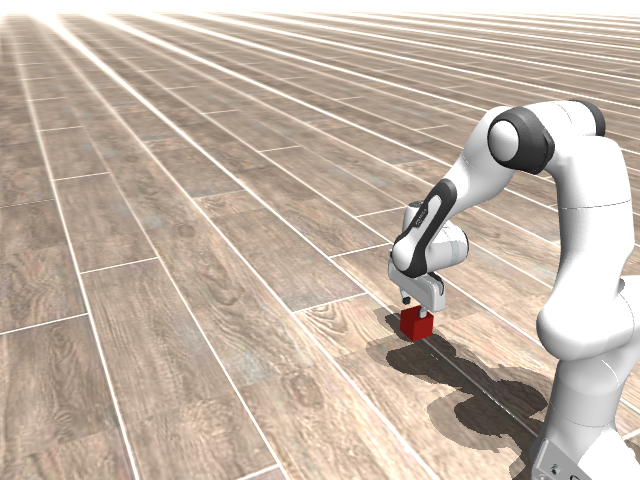

In [212]:
traj_saved = np.load("outputs/pick_and_place_traj11.npz", allow_pickle=True)
actions_MPC = traj_saved['arr_0']
states_traj = traj_saved['arr_1']

actions_MPC[:,:3]
actions_MPC[:,6]
states_traj[:,0,0,6]

Image.fromarray(traj_saved['arr_2'][1])

traj_saved.close()

In [53]:
[np.linalg.norm(states_traj[i][0,0][:3] + actions_MPC[i][:3] - states_traj[i+1][0,0][:3], 2) for i in range(0,5)]

[np.linalg.norm(actions_MPC[i][:3], 2) for i in range(0,5)]

np.linalg.norm(trajectory2['state'][:3] - states_traj[-1][0,0][:3].numpy(), 2)

C:\Users\gdev\AppData\Local\Temp\ipykernel_27216\3174192814.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  [np.linalg.norm(states_traj[i][0,0][:3] + actions_MPC[i][:3] - states_traj[i+1][0,0][:3], 2) for i in range(0,5)]


[np.float32(0.0009908101),
 np.float32(0.0009940531),
 np.float32(0.0009991503),
 np.float32(0.0009915158),
 np.float32(0.000998244)]

[np.float32(0.078011215),
 np.float32(0.088633575),
 np.float32(0.085066736),
 np.float32(0.063932486),
 np.float32(0.05700857)]

np.float64(0.297308779686186)

In [104]:
import imageio
import numpy as np

writer = imageio.get_writer("outputs/imgs_traj6_timestep.mp4", format="FFMPEG", fps=30)

#for frame in imgs_traj:
    #for _ in range(0, 30):
        #writer.append_data(frame)
        
for frame in env.frames:
    writer.append_data(frame)        

writer.close()

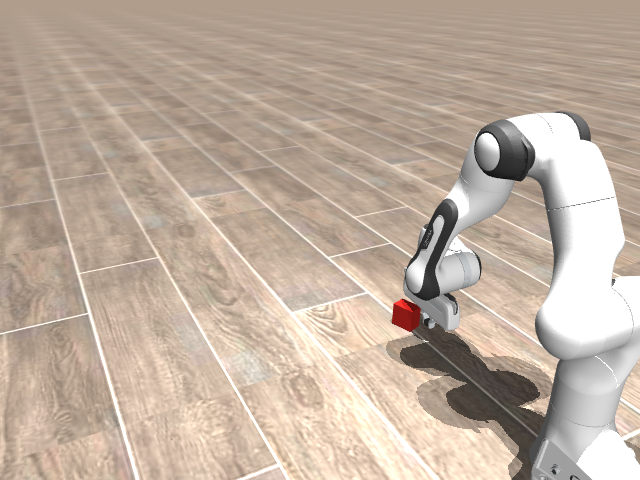

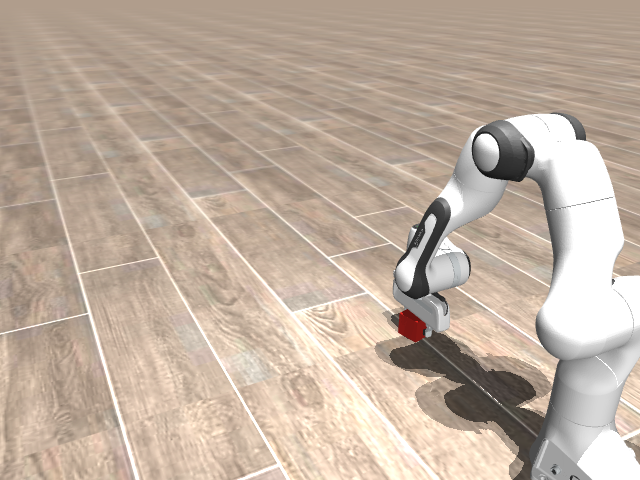

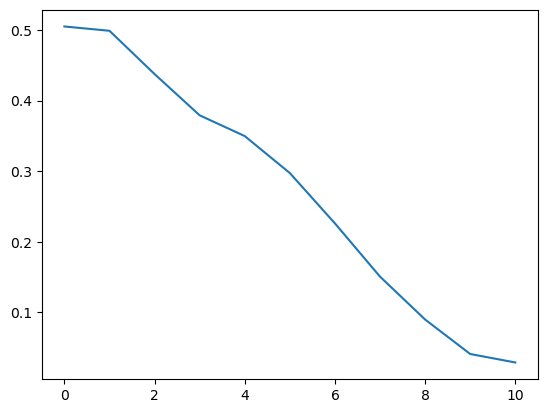

In [57]:
import matplotlib.pyplot as plt

Image.fromarray(img_t)
Image.fromarray(img_goal)

plt.plot([np.linalg.norm(trajectory2['state'][:3] - states_traj[i][0,0][:3].numpy(), 2) for i in range(len(states_traj))])

Testing camera angles

In [27]:
import numpy as np

def cosine_angle(a,b):
    cos = np.dot(a,b) / (np.linalg.norm(a, 2) * np.linalg.norm(b, 2))
    return np.arccos(cos) * 180/np.pi

env = PickPlacePandaEnv(
        "C:\\Users\\gdev\\Documents\\CS\\DL\\projects\\Robotics\\custom_gym_env\\robots/franka_emika_panda/pick_place_custom.xml",
        render_mode="rgb_array", camera_name='fixed_cam')

obs, info = env.reset()
    
start_xpos = np.array([0.5, 0])
    
cosine_angle(
    env.data.cam_xpos[0][:2] - start_xpos,
    np.array([0, 0]) - start_xpos)

np.float64(38.36461334398508)